In [166]:
#external stuff
import h5py
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.autograd import Variable
import cv2
import numpy as np
import math
import mahotas
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.feature_extraction.image import grid_to_graph
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation
import traceback
from uuid import uuid4 as unique_identifier
import random
import os
from time import perf_counter
from glob import glob
import pandas as pd

from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
import timm

In [173]:
#internal stuff
from contour_impl import do_contour_create, do_contour_compare
from imageprocessing import maybetogray,maybetocolor, image_preprocess, canny
from aberrations import aberrations

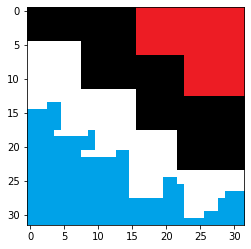

In [3]:
# load some test images
img_files=["stairtest.png","stairtest2.png","cornertest.png","cornertest2.png","cornertest3.png","cornertest4.png","tdl.png","tdl2.png","tokyo.png","tokyo2.png"]
test_images=[cv2.cvtColor(cv2.imread(iname), cv2.COLOR_BGR2RGB) for iname in img_files]
plt.imshow(test_images[0])

In [146]:
def log(kwargs,message):
    if 'log' in kwargs:
        if 'info' in kwargs:
            message['info']=kwargs['info']
        if 'type' in message and message['type']=='Error':
            message['traceback']=traceback.format_exc()
        kwargs['log'] += [message]

        
# each method is a triple of (name, create, compare),
# where
# name: describes the name of the method,
# create: creates a descriptor for a given image
# compare: returns a number indicating the similarity of two images
# each method naturally works on either color or black and white images,
# however we have the adapters grayto3 and gray which turn grayscale images into
# 3 channel images, and color images to grayscale respectively, so everything should work
# with either type of image.

# from the timm library we load multiple neural networks to use as image descriptors
timm_names=['cspdarknet53',
            'tf_efficientnetv2_l',
            'resnet50',
            'ecaresnetlight',
            'mixnet_s',
            'res2next50',
            'vit_small_r26_s32_224',
            'wide_resnet50_2']
# given a model name, load the model and return the method triple
def make_timm_method(modelname=timm_names[0], cuda=False):
    model = timm.create_model(modelname,pretrained=True,num_classes=0)
    if cuda:
        model = model.cuda()
    config = resolve_data_config({},model=model)
    transform = create_transform(**config)
    topil=transforms.ToPILImage()
    def create(img,**kwargs):
        try:
            img=maybetocolor(img)
            timg=topil(img)
            timg=transform(timg).unsqueeze(0)
            if cuda:
                timg=timg.cuda()
            return model(timg).squeeze().detach().numpy()
        except:
            log(kwargs,{'type':'Error', 'method':'Timm_'+modelname, 'fn':'create'})
            return None
    def compare(v1,v2,**kwargs):
        try:
            return np.dot(v1,v2)
        except:
            log(kwargs,{'type':'Error', 'method':'Timm_'+modelname, 'fn':'compare'})
            
    return {"name":'Timm_'+modelname, "create":create, "compare":compare}
        
# neural and small neural work on color images
def make_neural_method():
    # Load the pretrained model
    model = models.resnet18(pretrained=True)
    #strip the final layer to get a feature vector
    model = nn.Sequential(*list(model.children())[:-1])  
    # Set model to evaluation mode
    model.eval()

    def create(img,**kwargs):
        try:
            img=maybetocolor(img)
            scaler = transforms.Resize((224, 224))
            normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225])
            to_tensor = transforms.ToTensor()
            pillize = transforms.ToPILImage()
            loader = transforms.Compose([pillize, scaler, to_tensor, normalize])
            l_img = loader(img)
            t_img = Variable(l_img).unsqueeze(0)
            f_vec = model(t_img).squeeze()
            n_vec = f_vec.detach().numpy()
            n_vec = n_vec / np.linalg.norm(n_vec)
            return n_vec
        except:
            log(kwargs,{'type':'Error', 'method':'Neural', 'fn':'create'})
            return None

    def compare(v1, v2,**kwargs):
        try:
            return np.dot(v1, v2)
        except:
            log(kwargs,{'type':'Error', 'method':'Neural', 'fn':'compare'})
            return None   
        
    return {"name":"Neural", "create":create, "compare":compare}

def make_small_neural_method():
    class IconEmbeddingNet(nn.Module):
        def __init__(self):
            super().__init__()
            self.convnet = nn.Sequential(
                nn.Conv2d(3, 32, 5),
                nn.PReLU(),
                nn.MaxPool2d(2, stride=2),
                nn.Conv2d(32, 64, 5),
                nn.PReLU(),
                nn.MaxPool2d(2, stride=2))
            self.fc = nn.Sequential(
                nn.Linear(64 * 4 * 4, 256),
                nn.PReLU(),
                nn.Linear(256, 256),
                nn.PReLU(),
                nn.Linear(256, 8)
                )
        def forward(self, x):
            output = self.convnet(x)
            output = output.view(output.size()[0], -1)
            output = self.fc(output)
            return output

        def get_embedding(self, x):
            return self.forward(x)
        
    model = IconEmbeddingNet()
    model.load_state_dict(torch.load("models/IconEmbeddingNet.pt"))
    model.eval()
    
    def create(img,**kwargs):
        try:
            img=maybetocolor(img)
            scaler = transforms.Resize((28, 28))
            normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225])
            to_tensor = transforms.ToTensor()
            pillize = transforms.ToPILImage()
            loader = transforms.Compose([pillize, scaler, to_tensor, normalize])
            l_img = loader(img)
            t_img = Variable(l_img).unsqueeze(0)
            f_vec = model(t_img).squeeze()
            n_vec = f_vec.detach().numpy()
            return n_vec
        except:
            log(kwargs,{'type':'Error', 'method':'Small_Neural', 'fn':'create'})
            return None

    def compare(v1, v2,**kwargs):
        try:
            sim = 100.0/(np.linalg.norm(v1-v2)+1)
            return sim
        except:
            log(kwargs,{'type':'Error', 'method':'Small_Neural', 'fn':'compare'})
            return None
    
    return {"name":"Small_Neural", "create":create, "compare":compare}


def make_orb_method():
    orb = cv2.ORB_create()
    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    def create(img, **kwargs):
        try:
            img = maybetogray(img)
            # old image preprocessing
            # this will be moved to the more general framework
            img = cv2.resize(img,None, fx=13, fy=13, interpolation=cv2.INTER_AREA)

            # find the keypoints and descriptors with orb
            kp1, des1 = orb.detectAndCompute(img,None)
            if len(kp1) < 2:
                des1 = None
            return des1
        except:
            log(kwargs,{'type':'Error', 'method':'Orb', 'fn':'create'})
            return None

    def compare(img_kp1, img_kp2, **kwargs):
        try:
            matches = matcher.match(img_kp1,img_kp2)
            score = len(matches)
            return score
        except:
            log(kwargs,{'type':'Error', 'method':'Orb', 'fn':'compare'})
            return 0
        
    return {"name":"Orb", "create":create, "compare":compare}

def make_zernike_method():
    # image preprocessing
    def zcenter(img):
        _, _, min_x, min_y, max_x, max_y, edges1 = image_preprocess(img) 
        edges2 = edges1[min_y:max_y+1, min_x:max_x+1]
        edges2 = cv2.resize(edges2, dsize=(32, 32), interpolation=cv2.INTER_CUBIC)
        return edges2
    def create(img, **kwargs):
        try:
            img = maybetogray(img)
            #zcenter is the image preprocessing code that was here before,
            #but zernike_moments is the real functional part of the method
            # this will be moved to the more general framework
            edges2=zcenter(img)
            zernike = mahotas.features.zernike_moments(edges2, 16)  
            return normalize(zernike[:,np.newaxis], axis=0).ravel()
        except:
            log(kwargs,{'type':'Error', 'method':'Zernike', 'fn':'create'})
            return None

    def compare(x,y, **kwargs):
        try:
            return np.dot(x,y)
        except:
            log(kwargs,{'type':'Error', 'method':'Zernike', 'fn':'compare'})
            return 0
    return {"name":"Zernike", "create":create, "compare":compare}

def make_contour_method(fractions=[.05,.1,.15,.2,.25,.3,.35,.4,.45,.5,.55,.6,.65,.7,.75,.8,.85,.9,.95]):
    def create(img, **kwargs):
        try:
            return do_contour_create(img,fractions,**kwargs)
        except:
            log(kwargs,{'type':'Error', 'method':'Contour', 'fn':'create'})
            return None
        
    def compare(query1, query2, error=0.1, **kwargs):
        try:
            return do_contour_compare(query1, query2, fractions,error,**kwargs)
        except:
            log(kwargs,{'type':'Error', 'method':'Contour', 'fn':'compare'})
            return 0
    
    return {"name":"Contour", "create":create, "compare":compare}

our_methods=[make_timm_method, make_neural_method, make_small_neural_method, make_zernike_method, make_orb_method, make_contour_method]

class database:
    def __init__(self, method, images=[], preprocess=None, **kwargs):
        self.name = method["name"]
        self.create = method["create"]
        self.compare = method["compare"]
        self.preprocess = preprocess[1] if preprocess is not None else noop
        self.preprocessing_name = preprocess[0] if preprocess is not None else "None"
        self.db = {i:self.create(self.preprocess(images[i]), **kwargs) for i in range(len(images))}
        
    def find(self, img, candidates=None, others=[], should_sort=True, **kwargs):
        imgq = self.create(self.preprocess(img), **kwargs)
        candidates = candidates or self.db.keys()
        tmp_db = {-i:self.create(others[i], **kwargs) for i in range(len(others))}
        results = [(i, self.compare(imgq, self.db[i], **kwargs)) for i in candidates]
        tmp_results = [(i, self.compare(imgq, tmp_db[i], **kwargs)) for i in tmp_db.keys()]
        if should_sort:
            return sorted(results+tmp_results, key=lambda x: -x[1])
        else:
            return results+tmp_results

[]


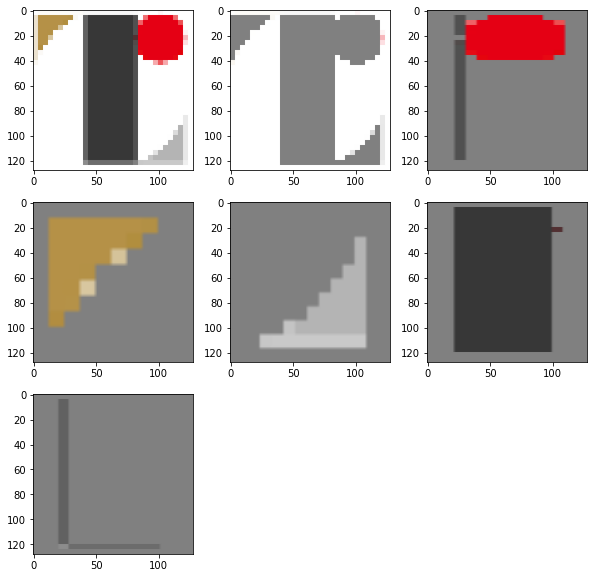

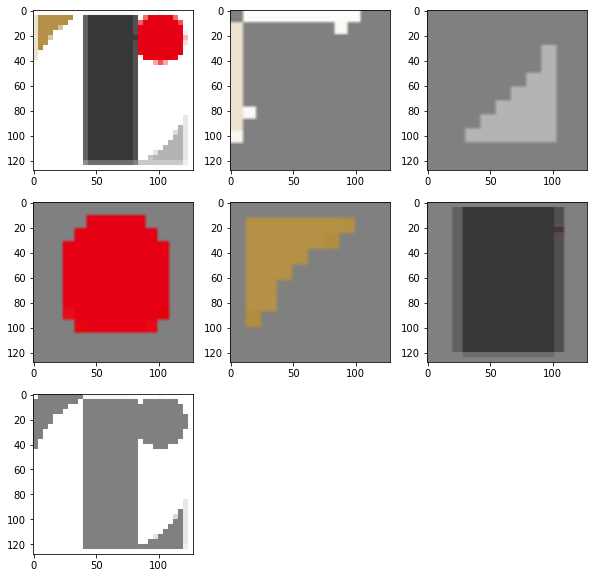

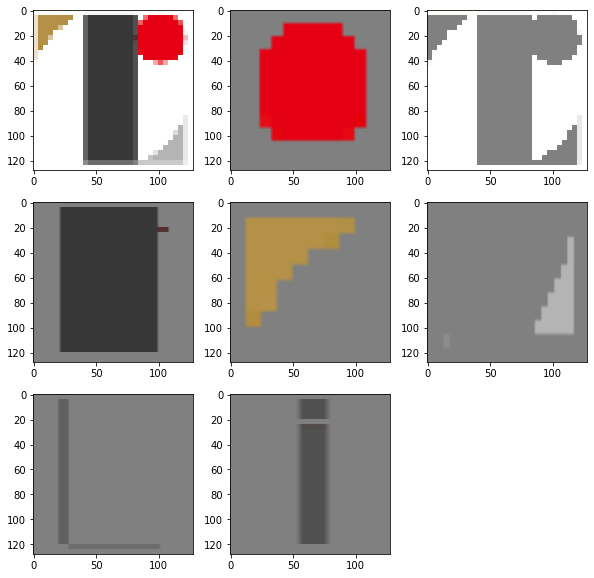

In [231]:
# image manipulation
# for all the different methods we first make a copy of the image just in case
# something decides to modify the original.
# Thank God for gigabytes of RAM
def stack(funcs):
    #compose several image manipulations 
    def nf(img):
        img=img[:]
        for f in funcs:
            img=f(img)
        return img
    return nf
def noop(img):
    return img
def color_reduce_kmeans(img, n_colors=8):
    img=img[:]
    h,w,c=img.shape
    fimg=np.clip(img.reshape(-1,3)/255,0.05,0.95)
    km=KMeans(n_clusters=n_colors,random_state=0).fit(fimg)
    means=np.clip(km.cluster_centers_,0.0,1.0)
    labels=km.predict(fimg)
    return (means[labels].reshape(img.shape)*255).astype(np.uint8)

def smooth_median(img,ks=5,n=2):
    img=img[:]
    for i in range(n):
        img=cv2.medianBlur(img,ks)
    return img
def std_size(img):
    img=img[:]
    return cv2.resize(img,(128,128),interpolation=cv2.INTER_AREA)

def big_size(img):
    return cv2.resize(img,None, fx=13, fy=13, interpolation=cv2.INTER_AREA)

# segmentation
def scast2(x,r):
        xpad=np.pad(x,[[0,0],[0,1]],mode="constant", constant_values=r)
        return xpad/np.linalg.norm(x,axis=1,keepdims=True)
def genkeys(n,d):
    r=np.random.normal(size=(n,d))
    r=r/np.linalg.norm(r,axis=1,keepdims=True)
    r=np.pad(r,[[1,0],[0,1]],mode="constant",constant_values=0)
    r[0,-1]=1
    return r
def meancolor(img,b):
    return np.floor(np.sum(img[b],(0)) / (0.01+np.sum(b))).astype(np.uint8)
def clamp(x, m,M):
    if x < m:
        return m
    if x > M:
        return M
    return x
def gsb(s,margin=10):
    h,w=s.shape
    x,y=np.where(s)
    x1=clamp(x.min()-margin,0,w)
    y1=clamp(y.min()-margin,0,h)
    x2=clamp(x.max()+margin,0,w)
    y2=clamp(y.max()+margin,0,h)
    return x1,y1,x2,y2
    #return x.min()-margin, y.min()-margin, x.max()+margin, y.max()+margin
def cropresize(img,b,bg=None,**kwargs):
    try:
        x1,y1,x2,y2=gsb(b)
        if bg is not None:
            img=img.copy()
            img[b!=True]=bg
        diff = max(x2-x1, y2-y1)
        xc = (x2+x1)/2
        yc = (y2+y1)/2
        return cv2.resize(img[x1:x2,y1:y2,:],img.shape[:-1])
    except:
        log(kwargs,{'type':'Error', 'method':'Segmentation', 'fn':'cropresize'})
        return None
def segment_labels(img,labels,bg=None,rejection=0.0,**kwargs):
    ulabels=np.unique(labels)
    h,w=labels.shape
    total=h*w
    masks=[labels==i for i in ulabels]
    # throw away any masks that cover less than 'rejection' percent of the image
    masks=[m for m in masks if np.sum(m) >= (rejection*total)]
    segs= [cropresize(img,b,bg,**kwargs) for b in masks]
    return [s for s in segs if s is not None]

def segment_agglomerative(img,n_shapes=10,bg=None,**kwargs):
    img=img[:]
    gimg=maybetogray(img)
    fimg=gimg.reshape(-1,1)
    connectivity = grid_to_graph(*gimg.shape)
    clustering = AgglomerativeClustering(n_clusters=n_shapes, linkage="ward",connectivity=connectivity).fit(fimg)
    labels=np.array(clustering.labels_).reshape(gimg.shape)
    return segment_labels(img,labels,bg=bg,**kwargs)

def segment_kmeans(img, n_colors=10, n_shapes=10,bg=None,**kwargs):
    img=img[:]
    h,w,c=img.shape
    fimg=np.clip(img.reshape(-1,3)/255,0.05,0.95)
    km=KMeans(n_clusters=n_colors,random_state=0).fit(fimg)
    means=np.clip(km.cluster_centers_,0.0,1.0)
    labels=np.array(km.predict(fimg)).reshape(*img.shape[:-1])
    return segment_labels(img,labels,bg=bg,**kwargs)

def segment_colors(img, threshold=.98,bg=None,**kwargs):
    # image is assumed to be HxWx3
    v=np.reshape(img,(-1,3))/255
    n=scast2(v-np.mean(v,0),0.01)
    r=genkeys(200,3)

    ids=np.argmax(n.dot(r.transpose()), axis=1)
    uids=np.unique(ids)
    w=np.array([np.sum(ids==i) for i in uids])/ids.size
    ws=np.argsort(-w)
    sids=uids[ws]
    csm=np.cumsum(w[ws])
    iids=np.array([sids[i] for i in range(1,len(sids)) if csm[i-1]<threshold])
    rids=ids.reshape(img.shape[:-1])
    return segment_labels(img,rids,bg=bg,**kwargs)

def plot_many(imgs,n_c=3):
    # convenience function to plot many images
    n_r = (len(imgs)//n_c)+1
    cc=1
    fig=plt.figure(figsize=(10,10))
    for i in imgs:
        fig.add_subplot(n_r,n_c,cc)
        plt.imshow(i)
        cc+=1
        
processing_pipelines = [
    None,
    ("color_reduce_kmeans", color_reduce_kmeans),
    ("smooth_median", smooth_median)
]
        
#plt.imshow(smooth_median(test_images[8],3,1))
#plt.imshow(smooth_median(color_reduce_kmeans(test_images[8],2),3,1))
rimg=std_size(test_images[7])
#rimg=color_reduce_kmeans(rimg,4)
#rimg=smooth_median(rimg,5,2)
#plt.imshow(rimg)
l=[]
segs=segment_agglomerative(rimg,log=l,bg=[128,128,128],rejection=0.02)
plot_many([rimg]+segs)
segs=segment_colors(rimg,log=l,bg=[128,128,128],rejection=0.02)
plot_many([rimg]+segs)
segs=segment_kmeans(rimg,log=l,bg=[128,128,128],rejection=0.02)
plot_many([rimg]+segs)
print(l)
#plt.imshow(smooth_median(color_reduce_kmeans(images[0])))

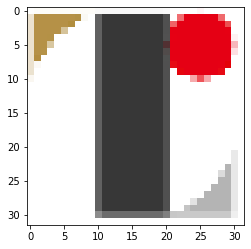

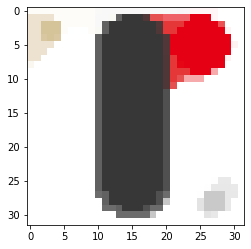

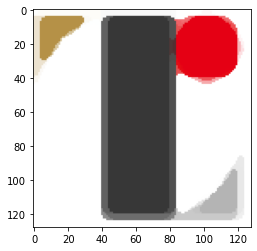

In [230]:
rimg=test_images[7]
rimg2=std_size(rimg)
plt.imshow(rimg)
plt.figure()
plt.imshow(smooth_median(rimg))
plt.figure()
plt.imshow(smooth_median(rimg2))

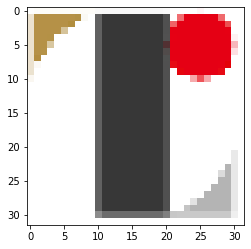

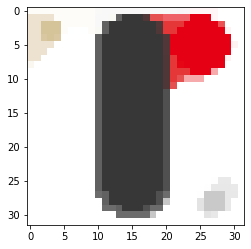

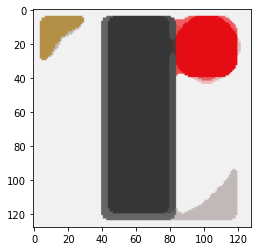

In [219]:
rimg=test_images[7]
rimg2=std_size(color_reduce_kmeans(rimg))
plt.imshow(rimg)
plt.figure()
plt.imshow(smooth_median(rimg))
plt.figure()
plt.imshow(smooth_median(rimg2))

In [225]:
qimg=aberrations[3](test_images[1])

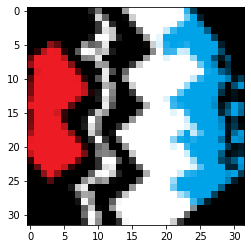

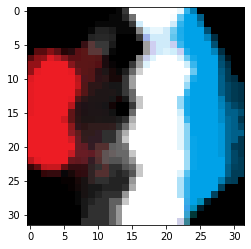

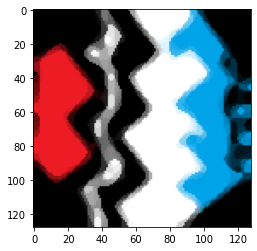

In [227]:
qimg2=std_size(qimg)
plt.imshow(qimg)
plt.figure()
plt.imshow(smooth_median(qimg))
plt.figure()
plt.imshow(smooth_median(qimg2))

In [245]:
image_set_name = "icon10"
logdir = "Logs20211008"

hdf5_file = h5py.File('LLD-icon.hdf5', 'r')
images, _ = (hdf5_file['data'], hdf5_file['labels/resnet/rc_64'])

# transpose the images because they're stored in a weird color channel first format, as indicated by shape[0] being 3
images = [np.transpose(i,(1,2,0)) if i.shape[0] == 3 else i for i in images[:100]]
running_images=images+test_images
print(len(images))
print("Loading Completed")

100
Loading Completed


In [246]:
loglist=[]
databases=[]
for method in our_methods:
    for proc in processing_pipelines:
        databases += [database(method(), running_images, log=loglist, preprocess=proc)]
        print("Another one bites the dust")
loglist

C:\Users\Ty\Anaconda3\envs\icon\lib\site-packages\torchvision\transforms\transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


Another one bites the dust


C:\Users\Ty\Anaconda3\envs\icon\lib\site-packages\ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.
C:\Users\Ty\Anaconda3\envs\icon\lib\site-packages\ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (8). Possibly due to duplicate points in X.
C:\Users\Ty\Anaconda3\envs\icon\lib\site-packages\ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (8). Possibly due to duplicate points in X.


Another one bites the dust


C:\Users\Ty\Anaconda3\envs\icon\lib\site-packages\torchvision\transforms\transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


Another one bites the dust
Another one bites the dust


C:\Users\Ty\Anaconda3\envs\icon\lib\site-packages\ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.
C:\Users\Ty\Anaconda3\envs\icon\lib\site-packages\ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (8). Possibly due to duplicate points in X.
C:\Users\Ty\Anaconda3\envs\icon\lib\site-packages\ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (8). Possibly due to duplicate points in X.


Another one bites the dust
Another one bites the dust
Another one bites the dust


C:\Users\Ty\Anaconda3\envs\icon\lib\site-packages\ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.
C:\Users\Ty\Anaconda3\envs\icon\lib\site-packages\ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (8). Possibly due to duplicate points in X.
C:\Users\Ty\Anaconda3\envs\icon\lib\site-packages\ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (8). Possibly due to duplicate points in X.


Another one bites the dust
Another one bites the dust
Another one bites the dust


C:\Users\Ty\Anaconda3\envs\icon\lib\site-packages\ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.
C:\Users\Ty\Anaconda3\envs\icon\lib\site-packages\ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (8). Possibly due to duplicate points in X.
C:\Users\Ty\Anaconda3\envs\icon\lib\site-packages\ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (8). Possibly due to duplicate points in X.


Another one bites the dust
Another one bites the dust
Another one bites the dust


C:\Users\Ty\Anaconda3\envs\icon\lib\site-packages\ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.
C:\Users\Ty\Anaconda3\envs\icon\lib\site-packages\ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (8). Possibly due to duplicate points in X.
C:\Users\Ty\Anaconda3\envs\icon\lib\site-packages\ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (8). Possibly due to duplicate points in X.


Another one bites the dust
Another one bites the dust
Another one bites the dust


C:\Users\Ty\Anaconda3\envs\icon\lib\site-packages\ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.
C:\Users\Ty\Anaconda3\envs\icon\lib\site-packages\ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (8). Possibly due to duplicate points in X.
C:\Users\Ty\Anaconda3\envs\icon\lib\site-packages\ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (8). Possibly due to duplicate points in X.


Another one bites the dust
Another one bites the dust


[]

In [176]:
loglist

[]

In [177]:
for db in databases:
    print(db.find(images[0], log=loglist))
loglist

[(0, 25.45041), (9, 18.414347), (4, 18.130966), (8, 17.679392), (2, 17.587751), (5, 17.313568), (1, 17.117708), (16, 16.77292), (19, 15.862336), (6, 15.449609), (3, 15.234795), (7, 14.88723), (13, 14.555244), (15, 14.392855), (14, 14.225763), (17, 14.189907), (12, 13.995571), (10, 13.514974), (18, 13.492008), (11, 13.369997)]
[(0, 19.983032), (8, 15.069709), (4, 14.921019), (6, 14.705055), (5, 14.649027), (2, 14.592595), (9, 14.253397), (17, 14.240539), (15, 13.435001), (1, 13.164028), (14, 13.119366), (18, 12.890629), (19, 12.453665), (11, 12.397472), (13, 12.212521), (3, 12.041096), (7, 12.014177), (12, 11.96661), (16, 11.61227), (10, 9.461657)]
[(0, 21.785782), (5, 16.771973), (8, 16.016361), (4, 16.012712), (1, 15.937252), (6, 14.299679), (9, 14.241036), (15, 14.209408), (12, 14.126558), (2, 14.088824), (7, 13.947339), (3, 13.921187), (11, 13.706778), (13, 13.333871), (16, 13.332869), (19, 13.078463), (14, 13.000101), (10, 12.978663), (18, 12.848738), (17, 12.084814)]
[(0, 0.999999

[]

In [178]:
# how to run your images
def chunks(x, n=100):
    for i in range(0, len(x), n):
        yield x[i:i+n]
def run(dbs,images,aberrations,candidates=None,logdir="Logs",report_every=10):
    if not os.path.exists("Logs"):
        os.mkdir("Logs")
    if not os.path.exists("Logs/"+logdir):
        os.mkdir("Logs/"+logdir)
    candidates=candidates or [i for i in range(len(images))]
    results={}
    imgs_so_far=0
    for img_idx in candidates:
        imgs_so_far+=1
        if imgs_so_far % report_every == 0:
            print(imgs_so_far)
        cimg=images[img_idx][:]
        for aber in aberrations:
            qimg=aber(cimg) if aber is not None else cimg
            for d in dbs:
                start_time=perf_counter()
                xl = d.find(qimg)
                rank=0
                for hit in xl:
                    rank+=1
                    if hit[0]==img_idx:
                        break
                duration = perf_counter() - start_time
                results.setdefault("aberration",[]).append(aber.__name__ if aber is not None else "ab_id")
                results.setdefault("method",[]).append(d.name)
                results.setdefault("preprocess",[]).append(d.preprocessing_name)
                results.setdefault("rank",[]).append(rank)
                results.setdefault("time",[]).append(duration)
    # save everything to file and return the dataframes
    results_pd = pd.DataFrame(data=results)
    log_num = len(glob("Logs/"+logdir+"/*")) + 1
    results_pd.to_csv ("Logs/"+logdir+'/results_'+str(log_num)+'.csv', index = None, header=True)
    return results_pd

def run_in_chunks(dbs,images,aberrations,chunksize=100,logdir="Logs"):
    candidates = [i for i in range(len(images))]
    random.shuffle(candidates)
    for chunk_num, candidate_chunk in enumerate(chunks(candidates,chunksize)):
        print("Chunk: " + str(chunk_num+1))
        run(dbs,images,aberrations,candidates=candidate_chunk,logdir=logdir)

In [179]:
res=run(databases,running_images,aberrations,logdir="test2")
res

C:\Users\Ty\Anaconda3\envs\icon\lib\site-packages\ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (8). Possibly due to duplicate points in X.
C:\Users\Ty\Anaconda3\envs\icon\lib\site-packages\ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (8). Possibly due to duplicate points in X.
C:\Users\Ty\Anaconda3\envs\icon\lib\site-packages\ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (8). Possibly due to duplicate points in X.
C:\Users\Ty\Anaconda3\envs\icon\lib\site-packages\ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (8). Possibly due to duplicate points in X.
C:\Users\Ty\Anaconda3\envs\icon\lib\site-packages\ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (8). Possibly due to duplicate poi

10


C:\Users\Ty\Anaconda3\envs\icon\lib\site-packages\ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (8). Possibly due to duplicate points in X.
C:\Users\Ty\Anaconda3\envs\icon\lib\site-packages\ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (8). Possibly due to duplicate points in X.
C:\Users\Ty\Anaconda3\envs\icon\lib\site-packages\ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (8). Possibly due to duplicate points in X.
C:\Users\Ty\Anaconda3\envs\icon\lib\site-packages\ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (8). Possibly due to duplicate points in X.
C:\Users\Ty\Anaconda3\envs\icon\lib\site-packages\ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (8). Possibly due to duplicate poi

C:\Users\Ty\Anaconda3\envs\icon\lib\site-packages\ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (8). Possibly due to duplicate points in X.
C:\Users\Ty\Anaconda3\envs\icon\lib\site-packages\ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (8). Possibly due to duplicate points in X.
C:\Users\Ty\Anaconda3\envs\icon\lib\site-packages\ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (8). Possibly due to duplicate points in X.
C:\Users\Ty\Anaconda3\envs\icon\lib\site-packages\ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (8). Possibly due to duplicate points in X.
C:\Users\Ty\Anaconda3\envs\icon\lib\site-packages\ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (5) found smaller than n_clusters (8). Possibly due to duplicate poi

C:\Users\Ty\Anaconda3\envs\icon\lib\site-packages\ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (8). Possibly due to duplicate points in X.
C:\Users\Ty\Anaconda3\envs\icon\lib\site-packages\ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (8). Possibly due to duplicate points in X.
C:\Users\Ty\Anaconda3\envs\icon\lib\site-packages\ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (8). Possibly due to duplicate points in X.
C:\Users\Ty\Anaconda3\envs\icon\lib\site-packages\ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (8). Possibly due to duplicate points in X.
C:\Users\Ty\Anaconda3\envs\icon\lib\site-packages\ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (8). Possibly due to duplicate poi

20


C:\Users\Ty\Anaconda3\envs\icon\lib\site-packages\ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (8). Possibly due to duplicate points in X.
C:\Users\Ty\Anaconda3\envs\icon\lib\site-packages\ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (8). Possibly due to duplicate points in X.
C:\Users\Ty\Anaconda3\envs\icon\lib\site-packages\ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (8). Possibly due to duplicate points in X.
C:\Users\Ty\Anaconda3\envs\icon\lib\site-packages\ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (8). Possibly due to duplicate points in X.
C:\Users\Ty\Anaconda3\envs\icon\lib\site-packages\ipykernel_launcher.py:19: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (8). Possibly due to duplicate poi

,aberration,method,preprocess,rank,time
0,ab_id,Timm_cspdarknet53,None,1,0.223943
1,ab_id,Timm_cspdarknet53,color_reduce_kmeans,1,0.298441
2,ab_id,Timm_cspdarknet53,smooth_median,1,0.217069
3,ab_id,Neural,None,1,0.030670
4,ab_id,Neural,color_reduce_kmeans,1,0.078566
...,...,...,...,...,...
3955,ab_draw_warp,Orb,color_reduce_kmeans,20,0.025414
3956,ab_draw_warp,Orb,smooth_median,20,0.000369
3957,ab_draw_warp,Contour,None,20,0.743858
3958,ab_draw_warp,Contour,color_reduce_kmeans,20,0.766382


Neural
color_reduce_kmeans


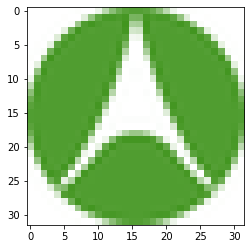

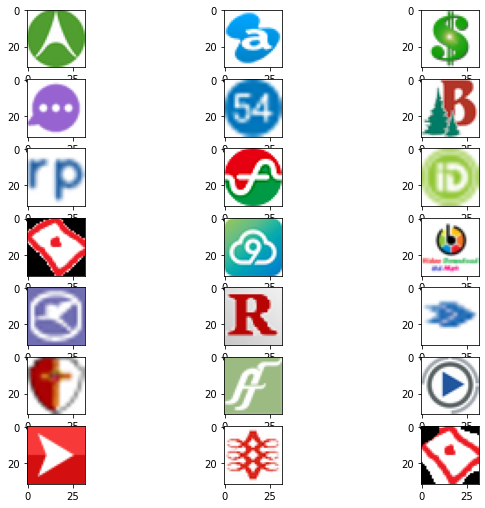

In [273]:
def show_in_order(xl,images):
    ims = [images[k[0]] for k in xl]
    plot_many(ims)
#qimg=aberrations[6](running_images[-1])
qimg=running_images[49]
dbnum=4
plt.imshow(qimg)
show_in_order(databases[dbnum].find(qimg)[:21], running_images)
print(databases[dbnum].name)
print(databases[dbnum].preprocessing_name)

In [212]:
logdir = "test2"
# Load all the logs into a single dataframe for processing
log_files = glob("Logs/"+logdir+"/*") # these are the logs that we're loading
print(log_files)
joined_logs = pd.concat([pd.read_csv(i) for i in log_files])
print(joined_logs)

['Logs/test2\\results_1.csv']
        aberration             method           preprocess  rank      time
0            ab_id  Timm_cspdarknet53                 None     1  0.223943
1            ab_id  Timm_cspdarknet53  color_reduce_kmeans     1  0.298441
2            ab_id  Timm_cspdarknet53        smooth_median     1  0.217069
3            ab_id             Neural                 None     1  0.030670
4            ab_id             Neural  color_reduce_kmeans     1  0.078566
...            ...                ...                  ...   ...       ...
3955  ab_draw_warp                Orb  color_reduce_kmeans    20  0.025414
3956  ab_draw_warp                Orb        smooth_median    20  0.000369
3957  ab_draw_warp            Contour                 None    20  0.743858
3958  ab_draw_warp            Contour  color_reduce_kmeans    20  0.766382
3959  ab_draw_warp            Contour        smooth_median    20  0.704501

[3960 rows x 5 columns]


Ranking


Text(0.5, 1.0, 'Small Neural')

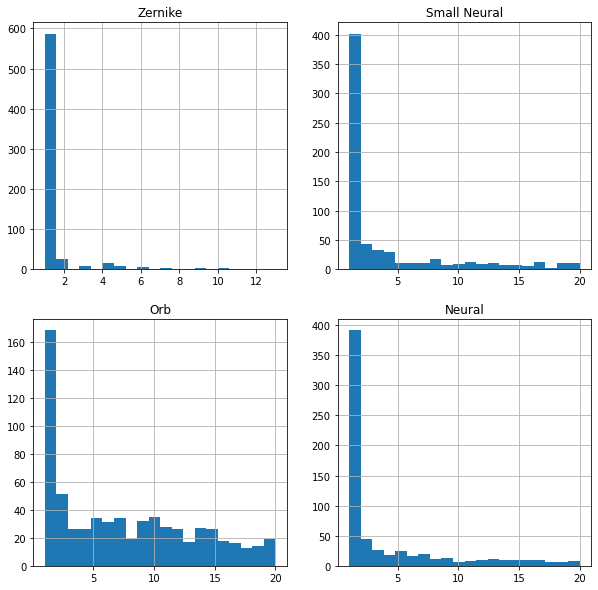

In [213]:
print("Ranking")
mpref=""
fig, axes = plt.subplots(nrows=2, ncols=2)
joined_logs[joined_logs['method']==mpref+'Neural']['rank'].hist(bins=20, figsize=(10,10), ax=axes[0,0])
axes[0,0].set_title('Zernike')
joined_logs[joined_logs['method']==mpref+'Timm_cspdarknet53']['rank'].hist(bins=20, figsize=(10,10), ax=axes[1,0])
axes[1,0].set_title('Orb')
joined_logs[joined_logs['method']==mpref+'Zernike']['rank'].hist(bins=20, figsize=(10,10), ax=axes[1,1])
axes[1,1].set_title('Neural')
#joined_logs[joined_logs['method']=='euclidean_neural_method']['rank'].hist(bins=20, figsize=(10,10), ax=axes[2,1])
#axes[2,1].set_title('Your Ad Here')
joined_logs[joined_logs['method']==mpref+'Contour']['rank'].hist(bins=20, figsize=(10,10), ax=axes[0,1])
axes[0,1].set_title('Small Neural')
#joined_logs[joined_logs['method']=='trained_neural_method']['rank'].hist(bins=20, figsize=(10,10), ax=axes[3,1])
#axes[3,1].set_title('Trained Neural')

In [ ]:
logs=[]
ms=[i() for i in all_methods]
for m in ms:
    v1=m[1](images[0],log=logs)
    v2=m[1](cimg,log=logs)
    m[2](v1,v2,log=logs)

In [ ]:
logs

In [ ]:
len(cimg.shape)

In [ ]:
np.repeat(cimg[...,np.newaxis],3,axis=2)

In [ ]:
import timm

In [ ]:
timm.list_models(pretrained=True)

In [268]:
databases[dbnum].find(qimg)[:21]

[(103, 0.99999994),
 (105, 0.91288984),
 (102, 0.90392363),
 (104, 0.85320306),
 (95, 0.7726576),
 (49, 0.76986253),
 (85, 0.7638229),
 (24, 0.75252426),
 (97, 0.75099623),
 (4, 0.74700177),
 (91, 0.74626327),
 (43, 0.74603754),
 (93, 0.7325289),
 (46, 0.726104),
 (55, 0.7260096),
 (57, 0.72592926),
 (54, 0.72542006),
 (11, 0.7170756),
 (34, 0.7139522),
 (27, 0.71162033),
 (5, 0.7089806)]

In [75]:
rimg=fimg[np.random.choice(fimg.shape[0],10)]
rimg

array([[241, 232, 194],
       [203, 175,  44],
       [253, 253, 249],
       [246, 242, 218],
       [234, 221, 165],
       [202, 174,  38],
       [255, 255, 255],
       [210, 187,  74],
       [254, 253, 250],
       [206, 180,  57]], dtype=uint8)

In [252]:
aberrations

[<function aberrations.ab_id(img)>,
 <function aberrations.ab_line(img)>,
 <function aberrations.ab_circle(img)>,
 <function aberrations.ab_rotate_border(img)>,
 <function aberrations.ab_translate_border(img)>,
 <function aberrations.ab_scale_border(img)>,
 <function aberrations.ab_affine_border(img)>,
 <function aberrations.ab_flip(img)>,
 <function aberrations.ab_draw(img)>,
 <function aberrations.ab_warp(img)>,
 <function aberrations.ab_draw_warp(img)>]

In [ ]:
# PIL ImageOps
img = ImageOps.fit(img, (int(rows  scale), int(cols  scale)), Image.ANTIALIAS)

In [ ]:
db1={i:i*5 for i in range(20)}

In [ ]:
a1=[i for i in db1.keys()]
a2 = [i for i in range(15)]
sorted(a1+a2)

In [ ]:
for t in timm_names:
    make_timm(t)